# XGBoost with SHAP for Confused Play Detection
This notebook trains an XGBoost model on NFL play data to predict 'confused plays' and uses SHAP for model explainability.

In [ ]:

import pandas as pd
import numpy as np
import os
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, precision_recall_curve
)
from sklearn.manifold import TSNE


# Load data
data_dir_for_modeling = '/home/tun62034/fuadhassan/nfl-data-bowl/Sample_Data/For_Modeling'

all_data = pd.read_parquet(os.path.join(data_dir_for_modeling, 'all_play.parquet'))
target = pd.read_parquet(os.path.join(data_dir_for_modeling, 'scoring_system.parquet'))
data = all_data.merge(target, on=['gameId', 'playId'], how='left')
data.fillna(0, inplace=True)

X = data.drop(columns=['gameId', 'playId', 'isConfusedPlay'])
y = data['isConfusedPlay']


/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Class 0: {neg}, Class 1: {pos}, scale_pos_weight: {scale_pos_weight:.2f}")


Class 0: 11693, Class 1: 1202, scale_pos_weight: 9.73


In [ ]:

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.7,
    subsample=0.7,
)

xgb_clf.fit(X_train, y_train)




/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:04:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

In [4]:
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

best_thresh = 0.5
best_f1 = 0

for thresh in np.arange(0.01, 0.9, 0.01):
    y_pred = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best F1: {best_f1:.4f} at threshold: {best_thresh:.2f}")


Best F1: 0.3590 at threshold: 0.51


In [5]:

y_pred = (y_proba >= best_thresh).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      2924
           1       0.29      0.47      0.36       300

    accuracy                           0.84      3224
   macro avg       0.62      0.68      0.64      3224
weighted avg       0.88      0.84      0.86      3224

Confusion Matrix:
 [[2584  340]
 [ 160  140]]
ROC AUC Score: 0.7901424988600092


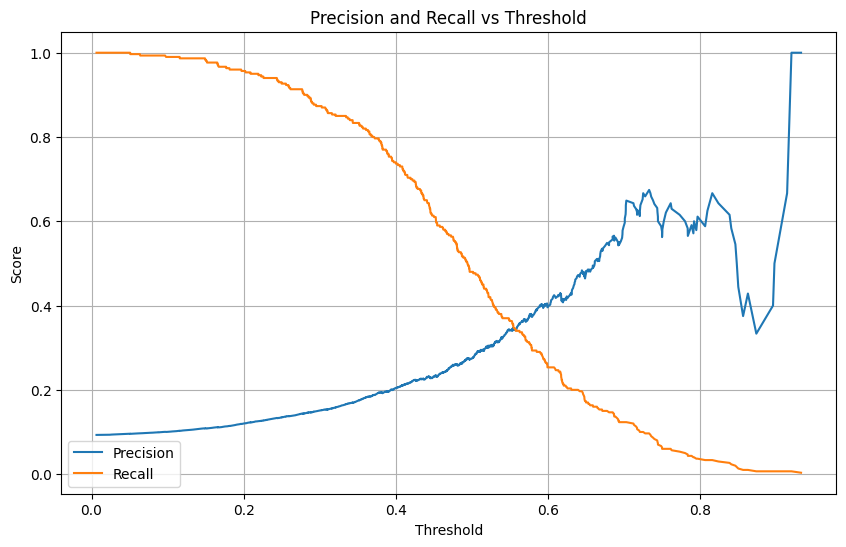

In [6]:

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


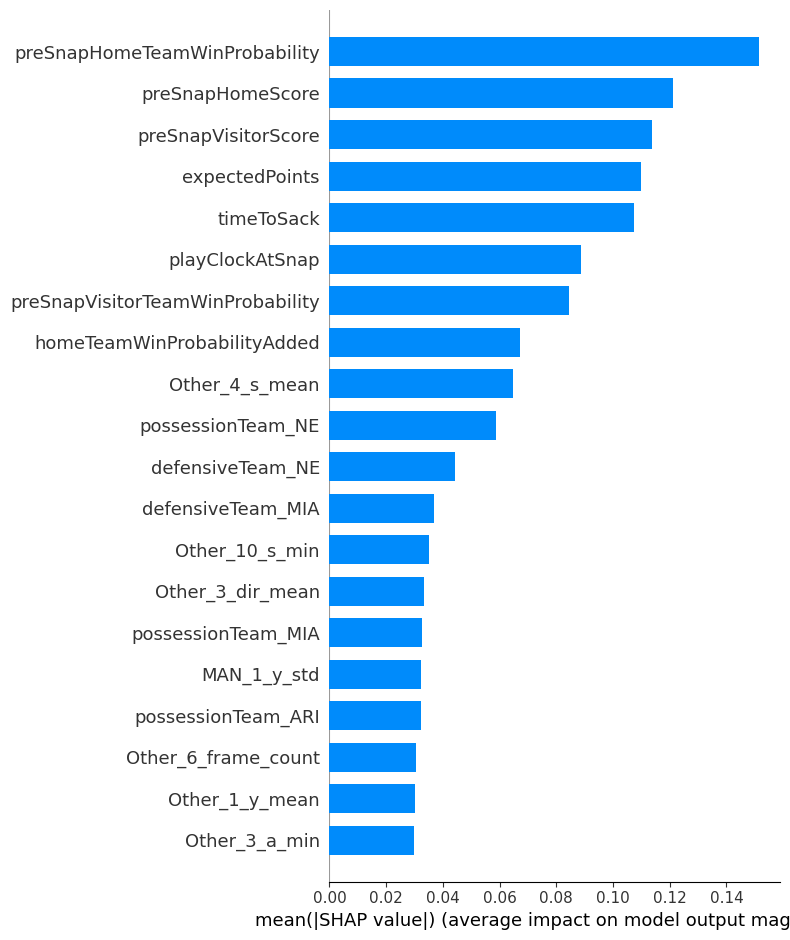

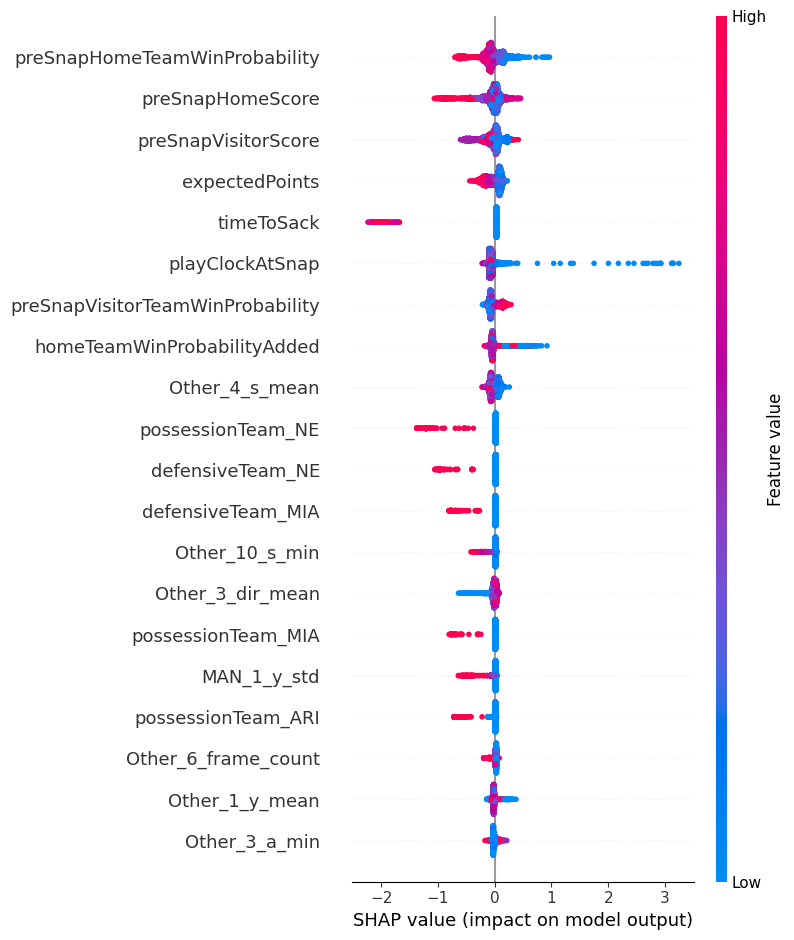

In [7]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

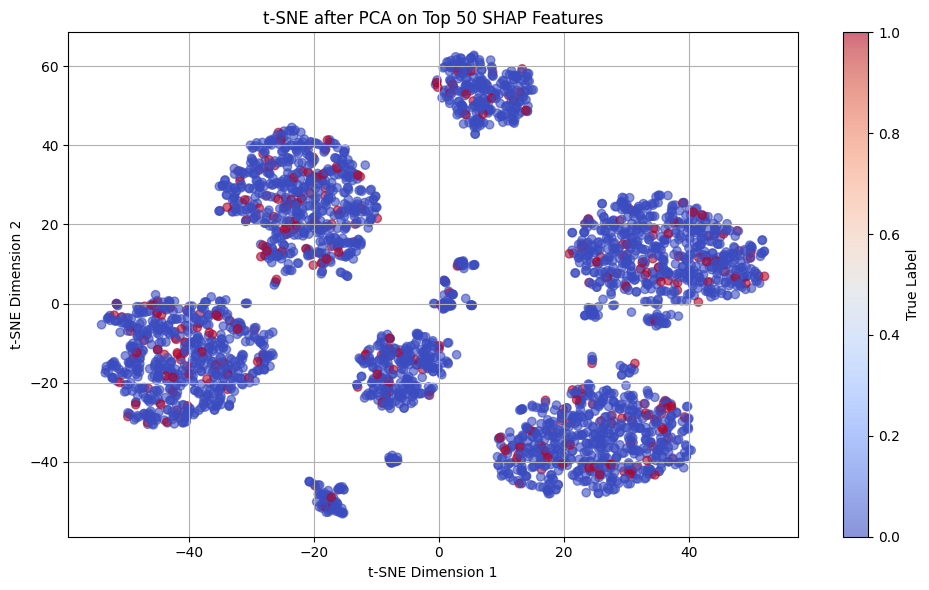

,TSNE-1,TSNE-2,True Label,Predicted Label
8633,-10.483641,-19.418077,0,0
3348,27.554291,2.287799,0,0
8213,-20.578663,29.916189,0,0
10955,-16.916796,28.540258,0,0
10530,-15.481072,35.219433,0,0


In [ ]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
feature_importance = np.abs(shap_values_df).mean(axis=0)
top_50_features = feature_importance.sort_values(ascending=False).head(50).index.tolist()
X_top50 = X_test[top_50_features]
pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X_top50)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)
tsne_df = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'True Label': y_test
})
try:
    tsne_df['Predicted Label'] = y_pred 
except NameError:
    pass  
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tsne_df['TSNE-1'], tsne_df['TSNE-2'],
    c=tsne_df['True Label'], cmap='coolwarm', alpha=0.6
)
plt.colorbar(scatter, label='True Label')
plt.title("t-SNE after PCA on Top 50 SHAP Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

tsne_df.head()
